### Introduction

Text classification algorithms are at the heart of a variety of software systems that process text data at scale. Email software uses text classification to determine whether incoming mail is sent to the inbox or filtered into the spam folder. 

Discussion forums use text classification to determine whether comments should be flagged as inappropriate.

These are two examples of topic classification, categorizing a text document into one of a predefined set of topics. In many topic classification problems, this categorization is based primarily on keywords in the text.

![](https://lh3.googleusercontent.com/-Cbc0UvkBpyc/Xz-67W-ST6I/AAAAAAAAppo/8ZBnwbQfa0kt3W2WwV0rOgNg7A3Olrn1gCK8BGAsYHg/s0/2020-08-21.png)

This project involves a preliminary text process, feature extraction and training the classifiers to distinguish spam or non-spam emails.

### Data
The Raw data we used is from Enron Corpus, which consists of 5172 training emails and 5857 testing emails in .txt format. Out of the 5172 training emails there are 1500 spam emails and 3672 ham emails. We are going to train the classification model with the training emails and to classify the testing set. Download data.zip in this repo for the email files.

In [1]:
import numpy as np
import pandas as pd
import time
import collections
import re
import random
import scipy.io
import glob

In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer,TfidfVectorizer
from sklearn import preprocessing
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import cross_val_score,GridSearchCV  #Perforing grid search
from sklearn.feature_selection import SelectKBest
from sklearn.naive_bayes import BernoulliNB

In [3]:
from nltk import PorterStemmer  # Text Processing
import pickle
pd.set_option('display.max_columns', None)

In [4]:
### Load the dictionary containing the dataset
pickle_in = open("Data/Enron.pkl",'rb') 
data_dict = pickle.load(pickle_in)

In [5]:
# dict to dataframe
df = pd.DataFrame.from_dict(data_dict, orient='index')
df.replace('NaN', np.nan, inplace = True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, METTS MARK to GLISAN JR BEN F
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   salary                     95 non-null     float64
 1   to_messages                86 non-null     float64
 2   deferral_payments          39 non-null     float64
 3   total_payments             125 non-null    float64
 4   loan_advances              4 non-null      float64
 5   bonus                      82 non-null     float64
 6   email_address              111 non-null    object 
 7   restricted_stock_deferred  18 non-null     float64
 8   deferred_income            49 non-null     float64
 9   total_stock_value          126 non-null    float64
 10  expenses                   95 non-null     float64
 11  from_poi_to_this_person    86 non-null     float64
 12  exercised_stock_options    102 non-null    float64
 13  from_messages              86 non-

In [6]:
df.head()

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,email_address,restricted_stock_deferred,deferred_income,total_stock_value,expenses,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
METTS MARK,365788.0,807.0,NaN,1061827.0,NaN,600000.0,mark.metts@enron.com,NaN,NaN,585062.0,94299.0,38.0,NaN,29.0,1740.0,1.0,False,NaN,702.0,585062.0,NaN
BAXTER JOHN C,267102.0,NaN,1295738.0,5634343.0,NaN,1200000.0,NaN,NaN,-1386055.0,10623258.0,11200.0,NaN,6680544.0,NaN,2660303.0,NaN,False,1586055.0,NaN,3942714.0,NaN
ELLIOTT STEVEN,170941.0,NaN,NaN,211725.0,NaN,350000.0,steven.elliott@enron.com,NaN,-400729.0,6678735.0,78552.0,NaN,4890344.0,NaN,12961.0,NaN,False,NaN,NaN,1788391.0,NaN
CORDES WILLIAM R,NaN,764.0,NaN,NaN,NaN,NaN,bill.cordes@enron.com,NaN,NaN,1038185.0,NaN,10.0,651850.0,12.0,NaN,0.0,False,NaN,58.0,386335.0,NaN
HANNON KEVIN P,243293.0,1045.0,NaN,288682.0,NaN,1500000.0,kevin.hannon@enron.com,NaN,-3117011.0,6391065.0,34039.0,32.0,5538001.0,32.0,11350.0,21.0,True,1617011.0,1035.0,853064.0,NaN


In [7]:
df.tail()

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,email_address,restricted_stock_deferred,deferred_income,total_stock_value,expenses,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
GRAMM WENDY L,NaN,NaN,NaN,119292.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,119292.0
CAUSEY RICHARD A,415189.0,1892.0,NaN,1868758.0,NaN,1000000.0,richard.causey@enron.com,NaN,-235000.0,2502063.0,30674.0,58.0,NaN,49.0,307895.0,12.0,True,350000.0,1585.0,2502063.0,NaN
TAYLOR MITCHELL S,265214.0,533.0,227449.0,1092663.0,NaN,600000.0,mitchell.taylor@enron.com,NaN,NaN,3745048.0,NaN,0.0,3181250.0,29.0,NaN,0.0,False,NaN,300.0,563798.0,NaN
DONAHUE JR JEFFREY M,278601.0,865.0,NaN,875760.0,NaN,800000.0,jeff.donahue@enron.com,NaN,-300000.0,1080988.0,96268.0,188.0,765920.0,22.0,891.0,11.0,False,NaN,772.0,315068.0,NaN
GLISAN JR BEN F,274975.0,873.0,NaN,1272284.0,NaN,600000.0,ben.glisan@enron.com,NaN,NaN,778546.0,125978.0,52.0,384728.0,16.0,200308.0,6.0,True,71023.0,874.0,393818.0,NaN


In [8]:
len(df[df['poi']])

18

There `146` Rows/observations and 21 Variables/Column are they in our dataset - 6 Email Features  and 14 financial features 1 POI label

<AxesSubplot:xlabel='salary', ylabel='bonus'>

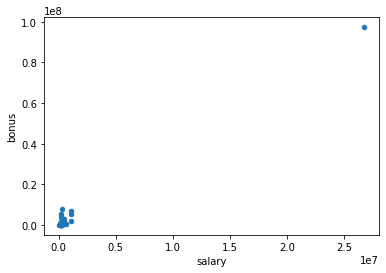

In [9]:
df.plot.scatter(x = 'salary', y = 'bonus')

In [10]:
df['salary'].idxmax()

'TOTAL'

<AxesSubplot:xlabel='salary', ylabel='bonus'>

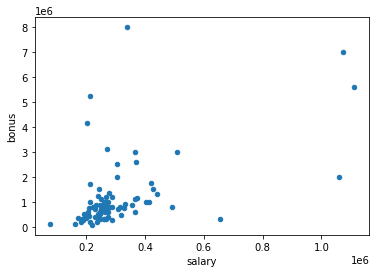

In [11]:
df.drop('TOTAL',inplace=True) # Total Row is Deleted
df.plot.scatter(x = 'salary', y = 'bonus')

In [12]:
df['fraction_from_poi'] = df['from_poi_to_this_person'] / df['to_messages']
df['fraction_to_poi'] = df['from_this_person_to_poi'] / df['from_messages']

<AxesSubplot:xlabel='fraction_from_poi', ylabel='fraction_to_poi'>

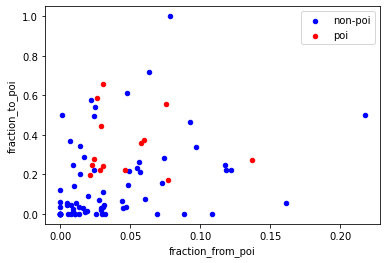

In [15]:
ax = df[df['poi']==False].plot.scatter(x='fraction_from_poi',y='fraction_to_poi',color='blue', label='non-poi')
df[df['poi']==True].plot.scatter(x='fraction_from_poi',y='fraction_to_poi',color='red', label='poi',ax=ax)

In [16]:
features_list = ['poi', 'salary', 'bonus', 'long_term_incentive', 'deferred_income', 'deferral_payments',
                 'loan_advances', 'other', 'expenses', 'director_fees', 'total_payments', 
                 'exercised_stock_options', 'restricted_stock', 'restricted_stock_deferred', 
                 'total_stock_value', 'to_messages', 'from_messages', 'from_this_person_to_poi', 
                 'from_poi_to_this_person', 'shared_receipt_with_poi', 'fraction_from_poi', 'fraction_to_poi']

In [17]:
filled_df = df.fillna(value='NaN')
data_dict = filled_df.to_dict(orient='index')

In [18]:
my_dataset = data_dict

In [20]:
my_dataset.keys()

dict_keys(['METTS MARK', 'BAXTER JOHN C', 'ELLIOTT STEVEN', 'CORDES WILLIAM R', 'HANNON KEVIN P', 'MORDAUNT KRISTINA M', 'MEYER ROCKFORD G', 'MCMAHON JEFFREY', 'HAEDICKE MARK E', 'PIPER GREGORY F', 'HUMPHREY GENE E', 'NOLES JAMES L', 'BLACHMAN JEREMY M', 'SUNDE MARTIN', 'GIBBS DANA R', 'LOWRY CHARLES P', 'COLWELL WESLEY', 'MULLER MARK S', 'JACKSON CHARLENE R', 'WESTFAHL RICHARD K', 'WALTERS GARETH W', 'WALLS JR ROBERT H', 'KITCHEN LOUISE', 'CHAN RONNIE', 'BELFER ROBERT', 'SHANKMAN JEFFREY A', 'WODRASKA JOHN', 'BERGSIEKER RICHARD P', 'URQUHART JOHN A', 'BIBI PHILIPPE A', 'RIEKER PAULA H', 'WHALEY DAVID A', 'BECK SALLY W', 'HAUG DAVID L', 'ECHOLS JOHN B', 'MENDELSOHN JOHN', 'HICKERSON GARY J', 'CLINE KENNETH W', 'LEWIS RICHARD', 'HAYES ROBERT E', 'KOPPER MICHAEL J', 'LEFF DANIEL P', 'LAVORATO JOHN J', 'BERBERIAN DAVID', 'DETMERING TIMOTHY J', 'WAKEHAM JOHN', 'POWERS WILLIAM', 'GOLD JOSEPH', 'BANNANTINE JAMES M', 'DUNCAN JOHN H', 'SHAPIRO RICHARD S', 'SHERRIFF JOHN R', 'SHELBY REX', 'LEMA

In [27]:
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

In [28]:
data = featureFormat(my_dataset, features_list, sort_keys = True)
data

array([[0.00000000e+00, 2.01955000e+05, 4.17500000e+06, ...,
        1.40700000e+03, 1.61957271e-02, 2.96127563e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 4.77000000e+02, 0.00000000e+00, ...,
        4.65000000e+02, 6.89045936e-02, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 1.58403000e+05, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [29]:
y, X = targetFeatureSplit(data)

In [30]:
X = np.array(X)
y = np.array(y)

In [33]:
### Cross-validation
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

SCALER = [None, StandardScaler()]
SELECTOR__K = [10, 13, 15, 18, 'all']
REDUCER__N_COMPONENTS = [2, 4, 6, 8, 10]

In [34]:
def evaluate_model(grid, X, y, cv):
    nested_score = cross_val_score(grid, X=X, y=y, cv=cv, n_jobs=-1)
    print("Nested f1 score: {}".format(nested_score.mean()))

    grid.fit(X, y)    
    print("Best parameters: {}".format(grid.best_params_))

    cv_accuracy = []
    cv_precision = []
    cv_recall = []
    cv_f1 = []
    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        grid.best_estimator_.fit(X_train, y_train)
        pred = grid.best_estimator_.predict(X_test)

        cv_accuracy.append(accuracy_score(y_test, pred))
        cv_precision.append(precision_score(y_test, pred))
        cv_recall.append(recall_score(y_test, pred))
        cv_f1.append(f1_score(y_test, pred))

    print ("Mean Accuracy: {}".format(np.mean(cv_accuracy)))
    print ("Mean Precision: {}".format(np.mean(cv_precision)))
    print ("Mean Recall: {}".format(np.mean(cv_recall)))
    print ("Mean f1: {}".format(np.mean(cv_f1)))